# Directed Search: Small-Difference Equilibrium with Y1 > Y2

## A partial solution to UBC Econ 514 Pset 2 Q3

James Yu, 12 February 2021

This notebook revises a procedure from [this notebook](https://github.com/jbrightuniverse/Directed-Search-Small-Difference-Wage-Equilibrium/blob/main/DirectedSearch.ipynb). For the most part, this notebook is functionally identical to the previous one.

It also formulates a solution for problem 3 of [this assignment](https://montoya.econ.ubc.ca/Econ514/problem_set_2.pdf).

[This other notebook](https://github.com/michaelpetersubc/notebooks/blob/master/Econ306/directed_search/directed_search_incomplete_information.ipynb) by Dr. Michael Peters, which we shall refer to hereafter as "the original notebook", describes the full extent of the solution for the Nash equilibrium $\pi_h$ and $\pi_l$ which is re-implemented here.

Unlike the previous iteration of this solution, this notebook implements grid search in Python instead of C++. In order to ensure that the grid search completes in a timely manner, values for $\lambda$, $y_1$ and $y_2$ are pre-fixed.

# Procedure

In this notebook, we will be demonstrating a corollary of the Directed Search model with incomplete information for firms' choices of wages. This is outlined in the assignment problem which should be read before continuing.

To do this, we will take a grid of values for $w_1$ and $w_2$, evaluate profit functions over the grid, and numerically construct a best-response set for each firm. The best-response values of $w_1$ and $w_2$ will, if the procedure works, show that the arguments from the assignment problem are satisfied.

First, we define our $\pi_h$ and $\pi_l$, which are piecewise based on inputs $w_1$, $w_2$ and $\lambda$. Here we use gamma instead of $\lambda$ to avoid issues with lambda being a reserved method name.

In [1]:
def pi_h(w1, w2, gamma):
    if (gamma*w1/2 + (1-gamma)*w1 > w2):
        return 1
    return ((gamma-2)*w2 + 2*w1)/(gamma*(w1+w2))

This above function is mostly a line by line transposition of the piecewise $\pi_h$ from the original notebook. The only change is that in the third case, we subtract the value from one as when we swap $w_1$ and $w_2$, this actually gives us the probability of applying to the second firm instead of the first.

In [2]:
def inner_pi_l(w1, w2, gamma):
    if (gamma*w1/2 + (1-gamma)*w1 > w2):
        return (2*(gamma-1)*w1 + (gamma + 1)*w2)/((gamma-1)*(w1+w2))
    return ((3-gamma)*w2 - 2*w1)/((1-gamma)*(w1+w2))

This function is also mostly line by line of $\pi_l$, with the only difference being the `1 -` term in the third case. However, this $\pi_l$ is insufficient for capturing the whole range of cases for $w_1$ and $w_2$, as we have cases where one of the two firms becomes dominated that these four cases do not capture. Instead of having to come up with the exact boundary conditions, we can simply constrain $\pi_l$ to be between zero and one, as these dominated cases result in $\pi_l$ taking on unrealistic values outside of $[0, 1]$. We could do the same thing for $\pi_h$ instead of having a full four cases, but for parity with the original notebook, we don't.

In [3]:
def pi_l(w1, w2, gamma):
    pi = inner_pi_l(w1, w2, gamma)
    if (pi > 1): 
        return 1
    elif (pi < 0): 
        return 0
    return pi

Now that we've defined functions for $\pi_h$ and $\pi_l$, we can define profit functions for the firms. These are direct implementations of the theoretical function example given at the end of the original notebook. The function for firm 1 was given, and the function for firm 2 is very similar; we simply invert the probabilities and apply the wage and revenue variables for firm 2 instead of firm 1.

In [4]:
def profit_1(w1, w2, gamma, y1, pi_hval, pi_lval):
    result = gamma**2 * (1-pi_hval**2)
    result += (1-gamma)**2 * (1-pi_lval**2)
    result += 2*gamma*(1-gamma)*(1-pi_hval)*(1-pi_lval)
    return (y1-w1)*(1-result)

def profit_2(w1, w2, gamma, y2, pi_hval, pi_lval):
    result = gamma**2 * pi_hval**2
    result += (1-gamma)**2 * pi_lval**2
    result += 2*gamma*(1-gamma)*pi_hval*pi_lval
    return (y2-w2)*(1-result)

Now, we want to find the equilibrium wage pairs that maximize firms' profits. This is where we conduct our grid search. We will define a function for a static $\lambda$, $y_1$ and $y_2$ selection, iterating over pairs of $w_1$ and $w_2$ to start with. We will evaluate both profit functions over the grid and construct a NumPy array to store them.

In [5]:
import numpy as np
global_precision = 100

In [24]:
def grid_exhaust(gamma, y1, y2, precision = global_precision):
    profit1 = np.NINF * np.ones((precision, precision))
    profit2 = np.NINF * np.ones((precision, precision))
    
    data = np.linspace(0.0000001, 1, precision)
    for j in range(precision): # iterate all w2
        for i in range(j+1, precision): # iterate only the relevant w1: this covers lower bound
            w1 = data[i]
            w2 = data[j]
            if w1 > (2*w2 / (1-gamma)):
                break # when w1 gets too high, stop and go to the next w2
                
            pi_hval = pi_h(w1, w2, gamma)
            pi_lval = pi_l(w1, w2, gamma)
            profit1[i,j] = profit_1(w1, w2, gamma, y1, pi_hval, pi_lval)
            profit2[i,j] = profit_2(w1, w2, gamma, y2, pi_hval, pi_lval)
            
    return profit1, profit2

We can now construct an exhausted grid with a precision variable specifying how big of a grid we want.

In [25]:
my_gamma = 0.6
my_y1 = 1
my_y2 = 0.8

exhausted_grid = grid_exhaust(my_gamma, my_y1, my_y2)

This pair of arrays gives a grid of evaluated profit values for the two firms given $w_1$, $w_2$ pairs. Given these pairs, we can iterate over the two arrays to find the best response wage pairs which maximize profits for a particular firm given the wage choice of the other firm.

In [26]:
def best_response(grid,gamma, precision = global_precision):
    profit1, profit2 = grid
    bestresponse1 = -1 * np.ones(precision, dtype = np.int64)
    bestresponse2 = -1 * np.ones(precision, dtype = np.int64)
    data = np.linspace(0.0000001, 1, precision)
    
    relevant_w1s = []
    for w2 in range(precision):
        argmax_1 = 0
        valmax_1 = 0
        
        # profit function matrices are stored as w1, w2 for both firms
        for w1 in range(w2 + 1, precision):
            if data[w1] > (2*data[w2]/ (1-gamma)):
                break
                
            relevant_w1s.append(w1)
                
            entry = profit1[w1,w2]
            if (entry > valmax_1):
                valmax_1 = entry
                argmax_1 = w1 # choice of w1, being used as first index
                
        bestresponse1[w2] = argmax_1
        
    for w1 in relevant_w1s:
        argmax_2 = 0
        valmax_2 = 0
        
        for w2 in range(precision):
            entry = profit2[w1,w2];
            if (entry > valmax_2):
                valmax_2 = entry
                argmax_2 = w2 # choice of w2, being used as second index
              
        bestresponse2[w1] = argmax_2
            
    return bestresponse1, bestresponse2

The above function takes the output of `grid_exhaust` and finds the argument $w_1$ and $w_2$ values which maximize profits given the opposing firm has chosen some wage value. The output is a single-dimensional numpy vector.

In [27]:
best_responses = best_response(exhausted_grid, my_gamma)

We have one best response for each of the `precision` number of entries in a single dimension of our original grid. Now that we have this data, we find equilibria by looking for matching pairs. That is, given a value $w_1$ that firm 1 chooses as a best response for some $w_2$ chosen by firm 2, if the best response of firm 2 to firm 1 choosing $w_1$ is to choose that same $w_2$, we have an equilibrium as it means there exists this outcome where both have maximized their profits by choosing a common pair of wages to set.

This is a direct implementation of best-response analysis in a discrete matrix game. When conducting the checks to find the strategy choice for which a player cannot deviate to achieve higher payoff, if there is some matrix entry containing an optimal strategy for both players, this is that same type of equilibrium.

In [28]:
import matplotlib.pyplot as plt

def equilibria(responses, gamma, plot = False):
    global global_precision
    bestresponse1, bestresponse2 = responses
    bestresponse1 = bestresponse1.astype(np.int64)
    bestresponse2 = bestresponse2.astype(np.int64)
    res = []
    for i in range(len(bestresponse1)):
        arg = bestresponse1[i]
        if bestresponse2[arg] == i:
            res.append([arg, i])
            
    if plot:
        fig, ax = plt.subplots()
        ws = np.linspace(0.0000001, 1, global_precision)
        plt.scatter([ws[x] for x in range(len(bestresponse1))], [ws[y] for y in bestresponse1], label = "f1 br")
        plt.scatter([ws[x] for x in bestresponse2], [ws[y] for y in range(len(bestresponse2))], label = "f2 br")
        plt.xlabel("w2")
        plt.ylabel("w1")
        plt.plot(ws, ws, label = "w1 = w2")
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1])
        plt.plot(ws, [w/(gamma/2 + (1-gamma)) for w in ws], label = "w1 = lambdathing")
        ax.legend()
        plt.show()
        
        
    
    return res

In the above function, we iterate over firm 1's best response choices of $w_1$, `arg`, to the corresponding $w_2$ specified by that index `i` of the vector. If firm 2's best response to firm 1's `arg` is to play `i` as $w_2$, we have an equilibrium.

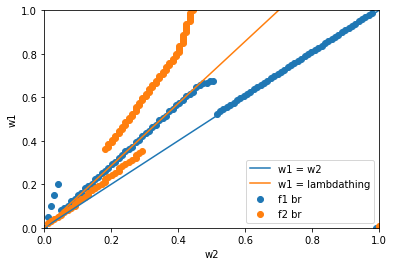

In [29]:
equilibriums = equilibria(best_responses, my_gamma, plot = True)

In [30]:
def report(gamma, equilibs, precision = global_precision, suppress = False):
    res = []
    ws = np.linspace(0.0000001, 1, precision)
    for data in equilibs:
        res.append([ws[data[0]], ws[data[1]]])

    if not suppress:
        print("Original data has", len(res), "entries")
        print(res)
    res = list(filter(lambda x: x[0] > x[1], res))
    if not suppress:
        print("w1 > w2 has", len(res), "entries")
    res = list(filter(lambda x: gamma*x[0]/2+(1-gamma)*x[0] <= x[1], res))
    if not suppress:
        print("Final result satisfied with", len(res), "entries")
    return res

In [31]:
report(my_gamma, equilibriums)

Original data has 0 entries
[]
w1 > w2 has 0 entries
Final result satisfied with 0 entries


[]

This means that for our original choices at the beginning of the notebook of $\lambda$, $y_1$ and $y_2$, we get these pairs of $w_1$ and $w_2$ as our wage equilibria. According to the filters, they satisfy all conditions.

We can now encapsulate everything we did into one single function so we can manipulate it.

In [ ]:
def do_everything(gamma, y1, y2, suppress = False):
    exhausted_grid = grid_exhaust(gamma, y1, y2)
    best_responses = best_response(exhausted_grid, gamma)
    equilibriums = equilibria(best_responses, gamma)
    return report(gamma, equilibriums, suppress = suppress)

In [ ]:
do_everything(0.5, 1, 0.6)

Let's do some graphing. We need to figure out where this is actually defined, so lets plot the results as a bar graph with $\lambda$ on the x-axis and number of equilibria on the y-axis. We'll set some arbitrary values of $y_1$ and $y_2$ on the time axis and form a dynamic graph.

In [ ]:
from io import BytesIO
from PIL import Image

images = []
for y2 in [0.8, 0.7, 0.6]:
    for y1 in [1]:
        if y1 == y2: continue
        data = []
        gammas = np.linspace(0.5, 0.9999, 10)
        for gamma in gammas:
            data.append(len(do_everything(gamma, y1, y2, suppress = True)))
            
        print(data)
        
        plt.clf()
        fig, ax = plt.subplots()
        plt.plot(gammas, data)

        fig.suptitle(f"Number of equilibria for Y1 = {round(y1, 2)}, Y2 = {round(y2, 2)}")
        plt.xlabel("λ")
        plt.ylabel("# of points")
        filex = BytesIO()
        ax.set_ylim(0, 2)
        fig.savefig(filex, format = "png")
        plt.close()
        filex.seek(0)
        images.append(filex)

imgs = [Image.open(image) for image in images]
masterfilex = BytesIO()
imgs[0].save(fp=masterfilex, format='GIF', append_images=imgs[1:], save_all=True, duration=400, loop=0)

# this is a GIF-displaying hack from https://stackoverflow.com/a/32108899
from IPython.display import HTML
from base64 import b64encode
HTML("<img src='data:image/gif;base64,{0}'/>".format(b64encode(masterfilex.getvalue()).decode('utf-8')))

Let's also try plotting some best-response functions.

In [ ]:
exhausted_grid = grid_exhaust(0.9, 1, 0.8)
best_responses = best_response(exhausted_grid, gamma)
equilibriums = equilibria(best_responses, plot = True)

In [ ]:
fig, ax = plt.subplots()
ws = np.linspace(0.0000001, 1, global_precision)
plt.scatter(ws, [pi_h(1, w, 0.8) for w in ws])
plt.xlabel("w2")
plt.ylabel("pi")
plt.show()

In [ ]:
def equilibria2(responses):
    global global_precision
    bestresponse1, bestresponse2 = responses
    fig, ax = plt.subplots()
    ws = np.linspace(0.0000001, 1, global_precision)
    plt.scatter([ws[x] for x in range(len(bestresponse2))], [pi_h(ws[bestresponse2[x]], ws[x], 0.8) for x in range(len(bestresponse1))])
    #plt.scatter([ws[x] for x in bestresponse2], [ws[y] for y in range(len(bestresponse2))])
    plt.xlabel("w1")
    plt.ylabel("pi_l")
    plt.show()

In [ ]:
exhausted_grid = grid_exhaust(0.8, 1, 0.8)
best_responses = best_response(exhausted_grid)
equilibria2(best_responses)

In [ ]:
fig, ax = plt.subplots()
ws = np.linspace(0.0000001, 1, global_precision)
for w in ws:
    plt.plot(ws, [pi_h(w, wx, 0.8) for wx in ws])
plt.xlabel("w1")
plt.ylabel("pi_h")
plt.show()

In [ ]:
fig, ax = plt.subplots()
ws = np.linspace(0.0000001, 1, global_precision)
for w in ws:
    plt.plot(ws, [pi_l(w, wx, 0.8) for wx in ws])
plt.xlabel("w1")
plt.ylabel("pi_l")
plt.show()